<a href="https://colab.research.google.com/github/1Aditya7/WResearch-PairTrading-StatArb/blob/main/WResearch_PairTrading_StatArb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quant Research Intern Assignment: Statistical Arbitrage - Pairs Trading**
Submitted by: Aditya Parthiban (aditya17parthiban@gmail.com)

In [116]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt

In [117]:
# Handling deprication warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## **Task 1:** Pair Selection and Data Preparation

### 1.1. Downloading and Cleaning The Data

In [118]:
# Defining stock tickers
tickers = ['HDFCBANK.NS', 'AXISBANK.NS']

In [119]:
# Defining time period of 3 years
end_date = "2023-12-31"
start_date = "2021-01-01"

In [120]:
# Downloading historical stock price data from Yahoo Finance
df = yf.download(tickers, start=start_date, end=end_date)['Adj Close'] #Prices adjusted for dividends and splits

df.head(10)

[*********************100%***********************]  2 of 2 completed


Ticker,AXISBANK.NS,HDFCBANK.NS
Date,,
2021-01-01,621.093750,1368.017578
2021-01-04,621.989929,1359.329590
2021-01-05,661.567505,1369.601440
2021-01-06,651.411743,1363.697632
2021-01-07,668.188660,1359.569702
2021-01-08,669.781738,1374.353394
2021-01-11,664.056641,1393.360718
2021-01-12,672.768738,1421.728271
2021-01-13,684.816162,1411.792603


### 1.2. Performing Exploratory Data Analysis (EDA)

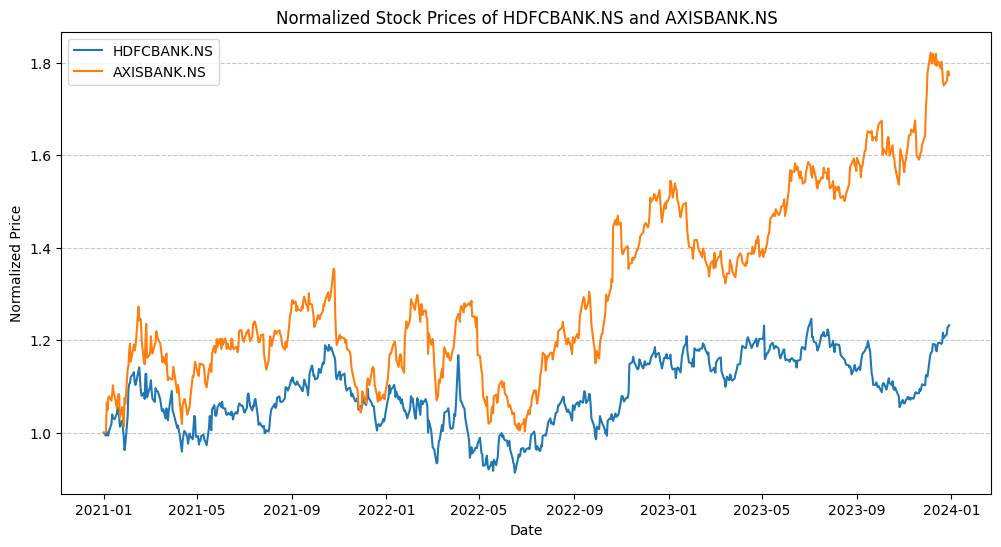

In [121]:
# Normalizing the stock prices by the first index
normalized_df = df / df.iloc[0]

# Plotting the normalized prices of the stocks
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(normalized_df[ticker], label=f"{ticker}")

plt.title(f"Normalized Stock Prices of {tickers[0]} and {tickers[1]}")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


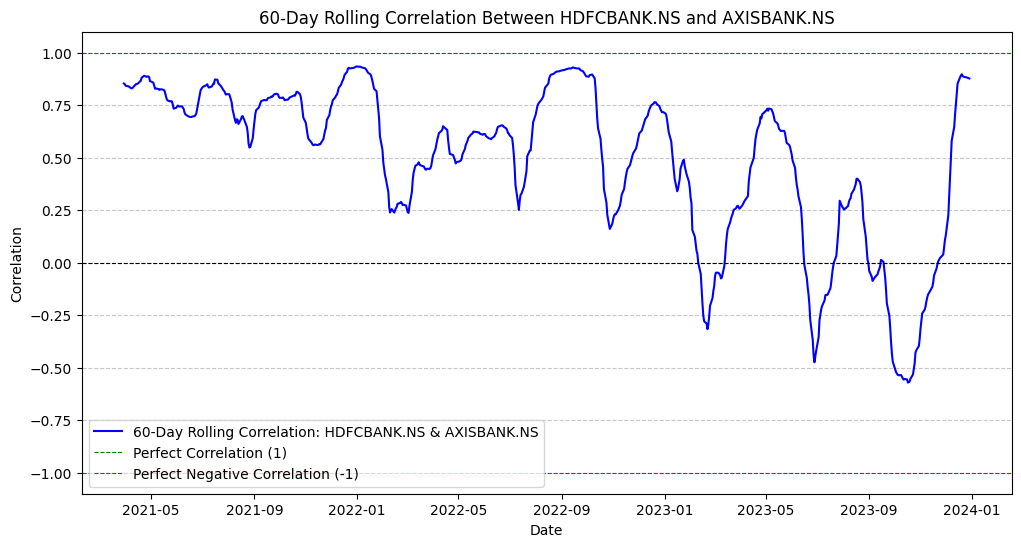

In [122]:
# Defining window for correlations and other analysis
window = 60

# Calculating the rolling correlation
rolling_corr = df[tickers[0]].rolling(window=window).corr(df[tickers[1]]) #60-days window in this case

# Plotting the rolling correlation
plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label=f"60-Day Rolling Correlation: {tickers[0]} & {tickers[1]}", color="blue")

plt.title(f"60-Day Rolling Correlation Between {tickers[0]} and {tickers[1]}")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at 0
plt.axhline(1, color="green", linestyle="--", linewidth=0.8, label="Perfect Correlation (1)")
plt.axhline(-1, color="red", linestyle="--", linewidth=0.8, label="Perfect Negative Correlation (-1)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Task 2:** Cointegration Testing using Engle-Granger Two-Step Method

### 2.1 Linear Regression using Oridnary Least Squares (OLS) Approach


#### Regression:
Regress one series (Y) on another (X) to estimate the relationship:
$$
y = \beta_0 + \beta_1 x + \epsilon
$$

Here, $ \epsilon $ is the residual.

In [123]:
# Step 1: Performing linear regression to get residuals
X = sm.add_constant(df[tickers[0]])  # Adding constant for intercept
y = df[tickers[1]]

# Fitting the linear model
model = sm.OLS(y, X).fit()

# Calculating residuals
residuals = model.resid

print(f"Regression Coefficients: {model.params}")


Regression Coefficients: const         -517.628344
HDFCBANK.NS      0.895675
dtype: float64


### 2.2. Augmented Dickey-Fuller (ADF) Test

In [124]:
from statsmodels.tsa.stattools import adfuller

# Step 2: Performing Augmented Dickey-Fuller (ADF) test on residuals
adf_stat, p_value, _, _, crit_vals, _ = adfuller(residuals)

# Printing ADF test results
print(f"ADF Statistic: {adf_stat}")
print(f"P-value: {p_value}")
print("Critical Values:")
print(f"1%: {crit_vals['1%']}")
print(f"5%: {crit_vals['5%']}")
print(f"10%: {crit_vals['10%']}")


ADF Statistic: -3.005942708640196
P-value: 0.03434314072588933
Critical Values:
1%: -3.4392177416762086
5%: -2.8654536415414684
10%: -2.5688540485756026


### 2.3 Cointergration Testing via Engle-Granger Two-Step Method using Built-In Function



 #### Calculate the Test Statistic:
 The ADF test statistic is derived from the t-statistic for 𝛾, which tests the null hypothesis:

   $$
   H_0: \gamma = 0 \quad (\text{Unit root exists, non-stationary})
   $$

   $$
   H_1: \gamma < 0 \quad (\text{No unit root, stationary})
   $$

In [125]:
from statsmodels.tsa.stattools import coint

# Perform the cointegration test using the built-in function from statsmodel
score, p_value, critical_values = coint(df[tickers[0]], df[tickers[1]])

# Printing the results
print(f"ADF Statistic: {score}")
print(f"P-value: {p_value}")
print("Critical Values:")
print(f"1%: {critical_values[0]}")
print(f"5%: {critical_values[1]}")
print(f"10%: {critical_values[2]}")


ADF Statistic: -3.7044847246402646
P-value: 0.01808355309894631
Critical Values:
1%: -3.9113010902118335
5%: -3.3443993517165813
10%: -3.050186318480643


#### Interpreting the p-value:

* $ p < 0.05 $ : Residuals are stationary, implying that the variables are cointegrated. \\
* $ p ≥ 0.05 $ : Residuals are not stationary, No cointegration.

#### Interpreting the Critical Values:
* The test compares the test statistic to the critical values.
* If the test statistic is less than the critical values at the 5% level, we reject the null hypothesis (no cointegration).

In [126]:
# Checking for cointegration
if p_value < 0.05:
 print(f"The pair {tickers[0]} and {tickers[1]} have a p-value of {p_value:.4f}. They are cointegrated and are suitable for pairs trading.")
else:
 print(f"The pair {tickers[0]} and {tickers[1]} have a p-value of {p_value:.4f}. They are not cointegrated and are unsuitable for pairs trading.")

The pair HDFCBANK.NS and AXISBANK.NS have a p-value of 0.0181. They are cointegrated and are suitable for pairs trading.


## **Task 3:** Building Pair Trading Strategy

### 3.1. Signal Generation

#### Spread Caclulation:

$$
\text{Spread}_t = \text{Price}_{\text{Asset 1}, t} - \text{Price}_{\text{Asset 2}, t}
$$

Where, t is a point in time

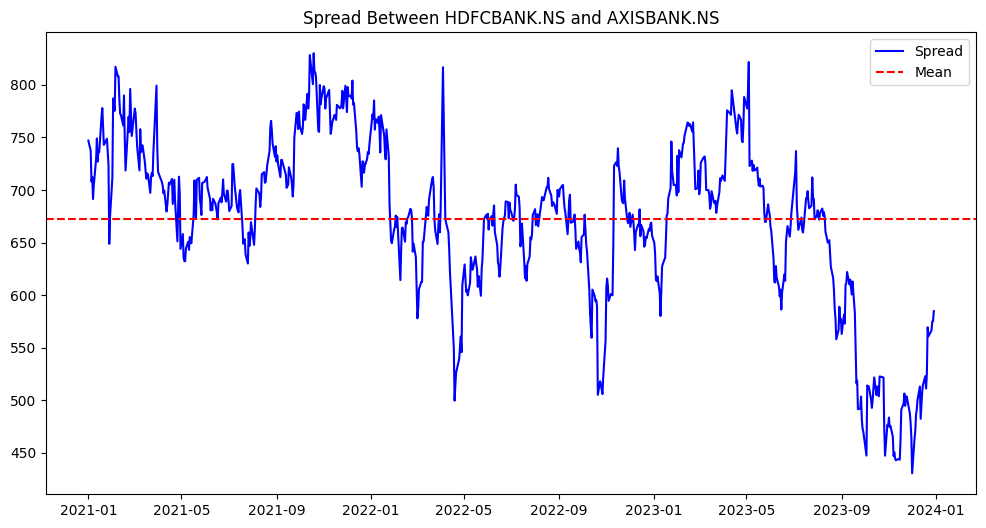

In [127]:
# Calculating the spread
spread = df[tickers[0]] - df[tickers[1]]

# Plotting the spread with the mean
plt.figure(figsize=(12, 6))
plt.plot(spread, label="Spread", color="blue")
plt.axhline(spread.mean(), color="red", linestyle="--", label="Mean")
plt.title(f"Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()

#### Z-Score Caclulation:

$$
Z_{\text{score}} = \frac{\text{Spread} - \mu}{\sigma}
$$

where: \\
𝜇 is the rolling mean \\
𝜎 is the rolling standard deviation

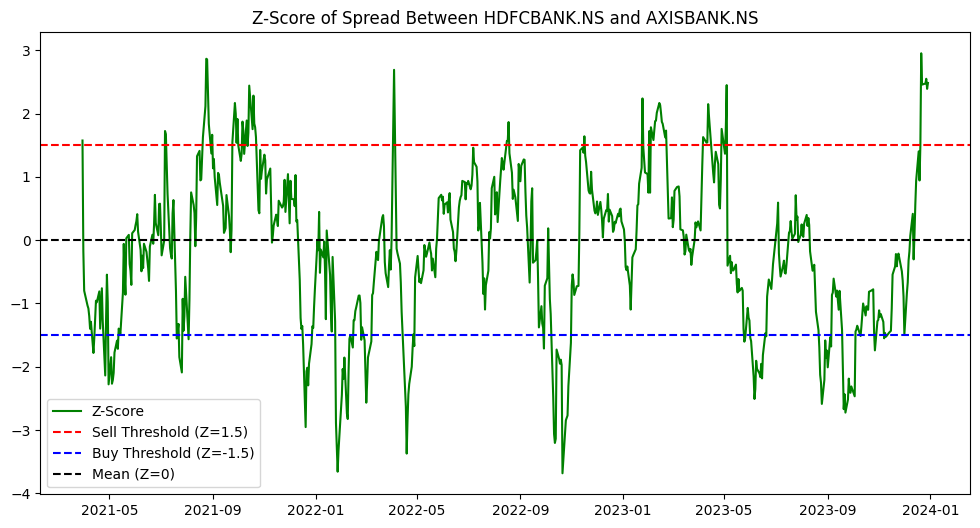

In [128]:
# Calculating rolling mean and standard deviation
rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

# Calculating Z-score
z_score = (spread - rolling_mean) / rolling_std

# Plotting the Z-score
plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score", color="green")
plt.axhline(1.5, color="red", linestyle="--", label="Sell Threshold (Z=1.5)")
plt.axhline(-1.5, color="blue", linestyle="--", label="Buy Threshold (Z=-1.5)")
plt.axhline(0, color="black", linestyle="--", label="Mean (Z=0)")
plt.title(f"Z-Score of Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()

In [129]:
# Defining thresholds for trading
buy_threshold = -1.5
sell_threshold = 1.5
exit_above_zero = 0
exit_below_zero = 0

# Initializing positions and tracking signals
position = 0  # 0: Neutral, 1: Long, -1: Short
positions = []  # Store the position at each time step
buy_signals = []  # Indexes of buy signals
sell_signals = []  # Indexes of sell signals
exit_signals = []  # Indexes of exit signals

### 3.2. Backtesting The Strategy

In [130]:
# Generating positions based on Z-score and thresholds
for i, z in enumerate(z_score):
    if position == 0:  # Neutral position

        if z < buy_threshold:
            position = 1  # Buy signal (Long position)
            buy_signals.append(i)

        elif z > sell_threshold:
            position = -1  # Sell signal (Short position)
            sell_signals.append(i)

    elif position == 1:  # Long position
        if z > exit_above_zero:
            position = 0  # Exit long position
            exit_signals.append(i)

    elif position == -1:  # Short position
        if z < exit_below_zero:
            position = 0  # Exit short position
            exit_signals.append(i)

    positions.append(position)  # Append the current position at each iteration

In [131]:
# Ensuring positions have the same length as the Z-score series
positions = positions[:len(z_score)]

# Adding positions to the DataFrame
signals = pd.DataFrame(index=z_score.index)
signals['Position'] = positions
signals['Buy'] = signals.index.isin(z_score.index[buy_signals])
signals['Sell'] = signals.index.isin(z_score.index[sell_signals])
signals['Exit'] = signals.index.isin(z_score.index[exit_signals])

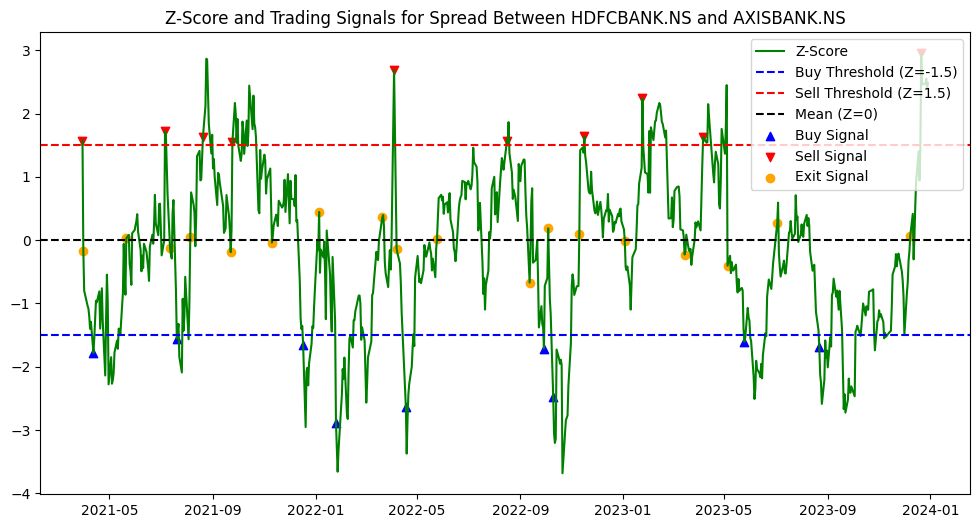

In [132]:
# Plotting the Z-score and signals
plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score", color="green")
plt.axhline(buy_threshold, color="blue", linestyle="--", label="Buy Threshold (Z=-1.5)")
plt.axhline(sell_threshold, color="red", linestyle="--", label="Sell Threshold (Z=1.5)")
plt.axhline(0, color="black", linestyle="--", label="Mean (Z=0)")

# Plotting the trading signals
plt.scatter(signals.index[signals['Buy']], z_score[signals['Buy']],
            label="Buy Signal", color="blue", marker="^")
plt.scatter(signals.index[signals['Sell']], z_score[signals['Sell']],
            label="Sell Signal", color="red", marker="v")
plt.scatter(signals.index[signals['Exit']], z_score[signals['Exit']],
            label="Exit Signal", color="orange", marker="o")
plt.title(f"Z-Score and Trading Signals for Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()


In [133]:
# Allocating equal capital for both stocks
initial_capital = 1000000  # INR Ten Lakhs
capital_per_stock = initial_capital / 2
df['Stock1_Position'] = capital_per_stock / df[tickers[0]].iloc[0]  # Position in Asset1
df['Stock2_Position'] = capital_per_stock / df[tickers[1]].iloc[0]  # Position in Asset2

$$
\text{Spread Return}_t = \frac{\text{Spread}_t - \text{Spread}_{t-1}}{\text{Spread}_{t-1}}
$$


Where, t is a point in time

In [134]:
# Storing the spread in the DataFrame
df['Spread'] = df[tickers[0]] - df[tickers[1]]

# Calculating the percentage change in spread
df['Spread_Return'] = (df['Spread'] - df['Spread'].shift(1)) / df['Spread'].shift(1)

print(df[['Spread', 'Spread_Return']].head())


Ticker          Spread  Spread_Return
Date                                 
2021-01-01  746.923828            NaN
2021-01-04  737.339661      -0.012832
2021-01-05  708.033936      -0.039745
2021-01-06  712.285889       0.006005
2021-01-07  691.381042      -0.029349


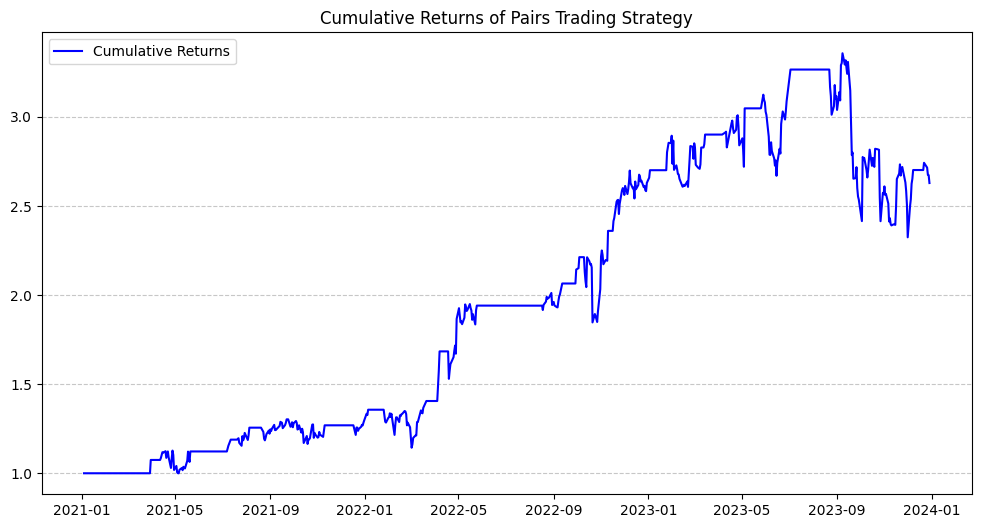

In [135]:
# Calculating percentage change in the spread
df['percentage_change'] = (df['Spread'] - df['Spread'].shift(1)) / df['Spread'].shift(1)

# Using signals['Position'] for strategy returns
df['Strategy_Returns'] = signals['Position'].shift(1) * df['percentage_change']

# Calculating cumulative returns
df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()

# Calculating total strategy returns
total_returns = (df['Cumulative_Returns'].iloc[-1] - 1) * 100

# Plotting cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Returns'], label="Cumulative Returns", color="blue")
plt.title(f"Cumulative Returns of Pairs Trading Strategy")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


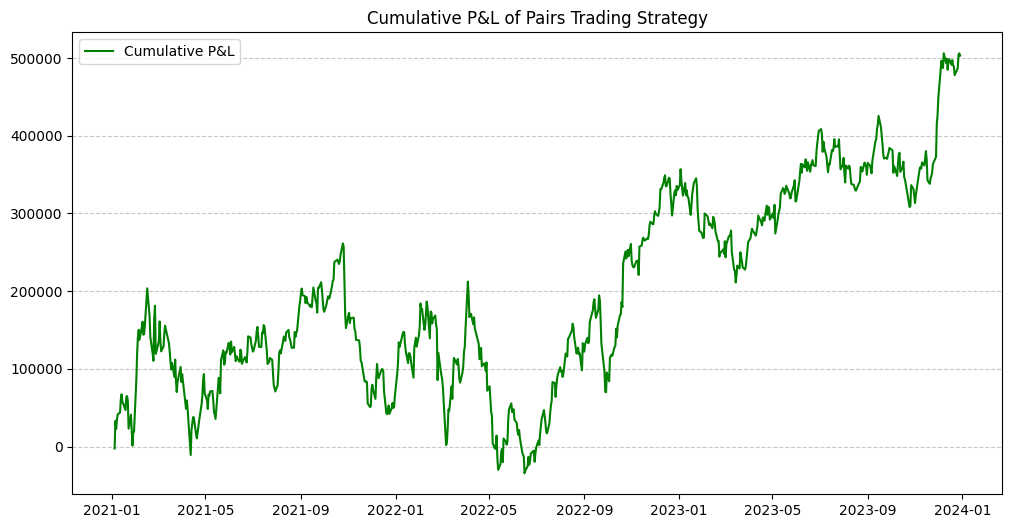

In [136]:
# Calculating the portfolio P&L
df['Strategy_PnL'] = (df['Stock1_Position'] * (df[tickers[0]] - df[tickers[0]].shift(1))) + \
                      (df['Stock2_Position'] * (df[tickers[1]] - df[tickers[1]].shift(1)))

# Calculating the cumulative P&L
df['Cumulative_PnL'] = df['Strategy_PnL'].cumsum()

# Plotting cumulative P&L for the strategy
plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_PnL'], label="Cumulative P&L", color="green")
plt.title(f"Cumulative P&L of Pairs Trading Strategy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


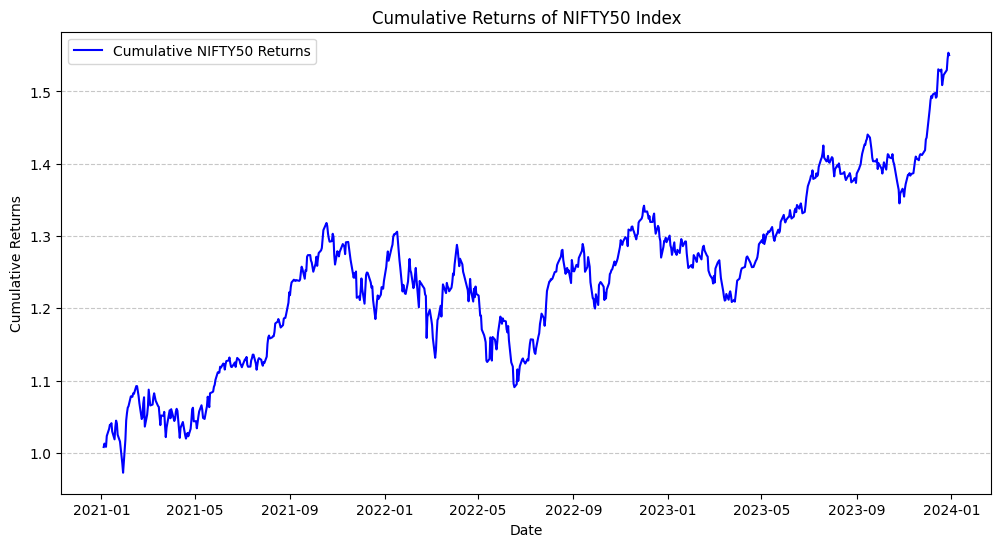

In [137]:
# Downloading NIFTY50 data to serve as benchmark
nifty50_data = yf.download('^NSEI', start=start_date, end=end_date)

# Calculating daily returns of NIFTY50
nifty50_data['NIFTY50_Returns'] = nifty50_data['Adj Close'].pct_change()

# Calculating cumulative returns of NIFTY50
nifty50_data['Cumulative_NIFTY50_Returns'] = (nifty50_data['NIFTY50_Returns'] + 1).cumprod()

# Adding NIFTY50 data to DataFrame
df['NIFTY50'] = nifty50_data['Adj Close']
df['NIFTY50_Returns'] = nifty50_data['NIFTY50_Returns']
df['Cumulative_NIFTY50_Returns'] = nifty50_data['Cumulative_NIFTY50_Returns']

# Plotting cumulative returns of NIFTY50
plt.figure(figsize=(12, 6))
plt.plot(nifty50_data['Cumulative_NIFTY50_Returns'], label="Cumulative NIFTY50 Returns", color="blue")
plt.title("Cumulative Returns of NIFTY50 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

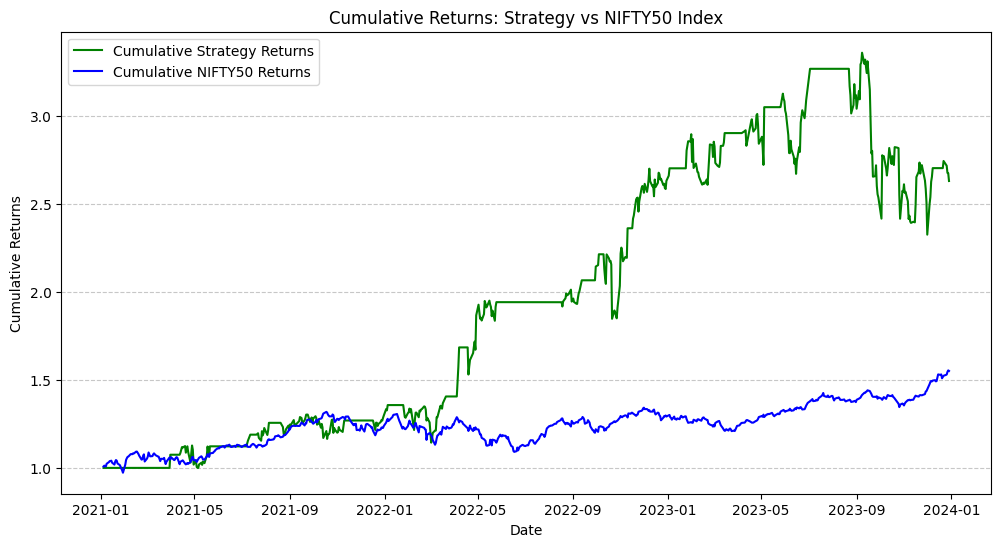

In [138]:
# Plotting cumulative returns of the strategy vs cumulative returns of the benchmarks (NIFTY50 index)
plt.figure(figsize=(12, 6))

# Plotting strategy cumulative returns
plt.plot(df['Cumulative_Returns'], label="Cumulative Strategy Returns", color="green")

# Plotting NIFTY50 cumulative returns
plt.plot(df['Cumulative_NIFTY50_Returns'], label="Cumulative NIFTY50 Returns", color="blue")


plt.title("Cumulative Returns: Strategy vs NIFTY50 Index")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## **Task 4:** Performance Analysis

#### Beta Calculation:

$$
\beta = \frac{\text{Cov}(\text{Strategy Returns}, \text{Benchmark Returns})}{\text{Var}(\text{Benchmark Returns})}
$$


#### Alpha Calculation:

$$
\alpha = \text{Annualized Strategy Return} - \left( \text{Risk-Free Rate} + \beta \times \left( \text{Annualized Benchmark Return} - \text{Risk-Free Rate} \right) \right)
$$


#### Sharpe Calculation:

$$
\text{Sharpe Ratio} = \frac{\text{Annualized Strategy Return} - \text{Risk-Free Rate}}{\text{Annualized Strategy Standard Deviation}}
$$


In [140]:
# Calculating Beta
cov_matrix = np.cov(df['Strategy_Returns'].dropna(), df['NIFTY50_Returns'].dropna())
beta = cov_matrix[0, 1] / cov_matrix[1, 1]

# Calculating Alpha
risk_free_rate = 0.04 / 252  # Assuming 4% annual risk-free rate by 252 trading days
strategy_return_annualized = df['Strategy_Returns'].mean() * 252  # Annualize strategy returns
benchmark_return_annualized = df['NIFTY50_Returns'].mean() * 252  # Annualize benchmark returns

alpha = strategy_return_annualized - (risk_free_rate + beta * (benchmark_return_annualized - risk_free_rate))

# Calculating Sharpe Ratio (annualized)
strategy_std_annualized = df['Strategy_Returns'].std() * np.sqrt(252)  # Annualize the standard deviation
sharpe_ratio = (strategy_return_annualized - risk_free_rate) / strategy_std_annualized

print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")


Alpha: 0.3557
Beta: 0.2348
Sharpe Ratio: 1.0969


#### Drawdown Calculation:

$$
\text{Drawdown} = \frac{\text{Cumulative Returns} - \text{Peak}}{\text{Peak}}
$$

\\
Maximum Drawdown: The largest drawdown over the entire period, representing the worst-case scenario.

Maximum Drawdown: -30.76%


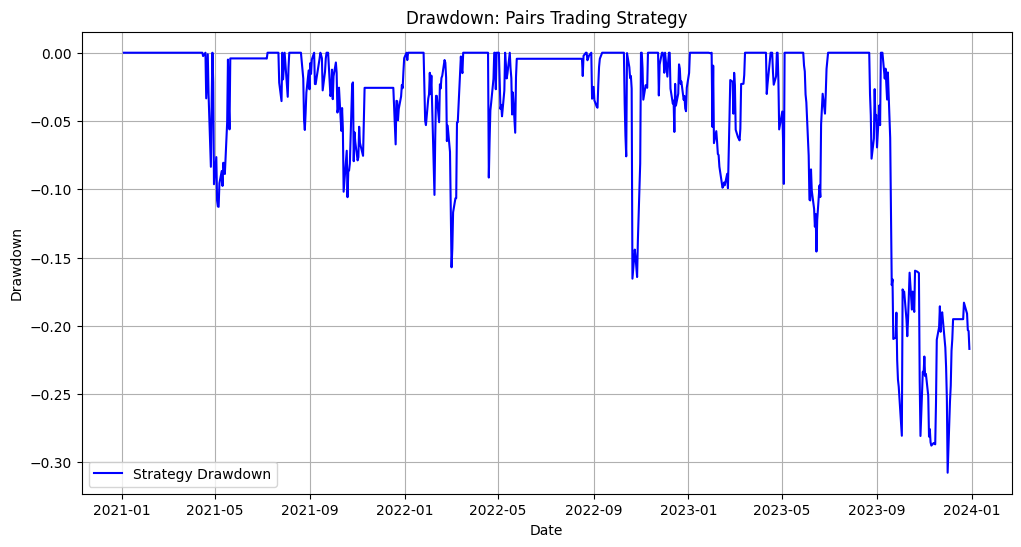

In [141]:
# Calculating the rolling peak (maximum value)
peak = df['Cumulative_Returns'].cummax()

# Calculating the drawdown
strategy_drawdown = (df['Cumulative_Returns'] - peak) / peak

# Calculating the maximum drawdown
strategy_max_drawdown = strategy_drawdown.min()

# Adding the drawdowns to the DataFrame for plotting
df['Strategy_Drawdown'] = strategy_drawdown


print(f"Maximum Drawdown: {strategy_max_drawdown:.2%}")

# Plot strategy drawdown
plt.figure(figsize=(12, 6))
plt.plot(df['Strategy_Drawdown'], label="Strategy Drawdown", color="blue")
plt.title("Drawdown: Pairs Trading Strategy")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True)
plt.show()

##### Win-Rate Calculation:

$$
\text{Win Rate} = \frac{\text{Number of Winning Trades}}{\text{Total Trades}} \times 100
$$

In [142]:
# Identifying trades (position changes)
df['Trade'] = signals['Position'].diff().fillna(0)

# Filtering rows where a trade occurs
trades = df[df['Trade'] != 0].copy()

# Adding trade return (cumulative returns at entry and exit points)
trades['Trade_Return'] = trades['Cumulative_Returns'].diff().fillna(0)

# Identifying winning trades (positive returns)
winning_trades = trades[trades['Trade_Return'] > 0]

# Calculating the win rate
total_trades = len(trades) - 1  # Excluding the first row as it's not a complete trade
winning_trades_count = len(winning_trades)
win_rate = (winning_trades_count / total_trades) * 100 if total_trades > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades_count}")
print(f"Win Rate: {win_rate:.2f}%")


Total Trades: 36
Winning Trades: 16
Win Rate: 44.44%


Excess Return Calculation:

$$ Excess Return = Total Strategy Returns - Total Benchmark Returns $$

In [143]:
# Calculating total return of the strategy
total_strategy_return = (df['Cumulative_Returns'].iloc[-1] - 1) * 100

# Calculating total return of the NIFTY50 index
total_nifty_return = (df['Cumulative_NIFTY50_Returns'].iloc[-1] - 1) * 100

print(f"Total Return of Strategy: {total_strategy_return:.2f}%")
print(f"Total Return of NIFTY50 Benchmark: {total_nifty_return:.2f}%")

# Calculating excess return (comparing strategy vs benchmark)
excess_return = total_strategy_return - total_nifty_return

print(f"Excess Return: {excess_return:.2f}%")


Total Return of Strategy: 162.85%
Total Return of NIFTY50 Benchmark: 55.02%
Excess Return (Strategy - Benchmark): 107.84%


#### PnL Ratio Cacluation:
$$
\text{PnL Ratio} = \frac{\text{Total Profit}}{\text{Total Loss}}
$$

In [144]:
# Calculating daily PnL for the strategy (based on initial capital)
df['PnL'] = df['Strategy_Returns'] * initial_capital

# Separating profits and losses
df['Profit'] = df['PnL'].apply(lambda x: x if x > 0 else 0)  # Only positive PnL (profits)
df['Loss'] = df['PnL'].apply(lambda x: abs(x) if x < 0 else 0)  # Only negative PnL (losses)

# Calculating total profit and total loss
total_profit = df['Profit'].sum()
total_loss = df['Loss'].sum()

# Calculating PnL Ratio
pnl_ratio = total_profit / total_loss if total_loss != 0 else float('inf')  # Avoiding division by zero

print(f"PnL Ratio: {pnl_ratio:.2f}")


PnL Ratio: 1.30


### Future Scope of Improvement:

- **Enhance Risk-Return Metrics**: Focus on improving the Sharpe ratio and reducing maximum drawdown to achieve optimized portfolio performance.

- **Automate Stock Screener for Pairs Trading**: Design a system using hierarchical clustering to identify sector-specific pairs, enabling better trade diversification.

- **Implement Dynamic Threshold Adjustment**: Leverage machine learning to refine z-thresholds and buy/sell signals, adapting to market volatility for precise trading strategies.

- **Incorporate Risk Management**: Introduce stop-loss levels, trade sizing, and volatility-based adjustments to mitigate potential losses.

- **Account for Realistic Performance Factors**: Include transaction costs and slippage in backtesting for more robust strategy validation.
